In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

In [3]:
our_indiv_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition"

In [4]:
def yolo_to_pixel(coord, img_W, img_H):
    """
    Compute the coordinates of the bbox in pixels term.

    Args:
        coord (tuple): Bbox in YOLO format.
        img_W (int): Width of the image.
        img_H (int): Height of the image.

    Returns:
        tuple: The coordinate of the top left an the bottom right corner of the bbox in pixel term.
    """ 
    x, y, w, h = coord
    
    x1 = max(0, int((x - w / 2) * img_W)) 
    y1 = max(0, int((y - h / 2) * img_H))
    x2 = min(img_W, int((x + w / 2) * img_W))
    y2 = min(img_H, int((y + h / 2) * img_H))

    return x1, y1, x2, y2

def face_to_yolo_relative_to_body(body_bbox, face_bbox):
    """
    Compute the coordinates of the bbox of the face relative to the bbox of the body.

    Args:
        body_bbox (tuple): Bbox of the body in YOLO format.
        face_bbox (tuple): Bbox of the face in YOLO format.

    Returns:
        tuple: The coordinate of the face relatively to the body in YOLO format.
    """ 
    bx1, by1, bx2, by2 = body_bbox 
    fx1, fy1, fx2, fy2 = face_bbox  
    
    if fx1 < bx1: 
        fx1 = bx1
    if fy1 < by1: 
        fy1 = by1
    if fx2 > bx2: 
        fx2 = bx2
    if fy2 > by2: 
        fy2 = by2

    # Taille du bounding box du corps
    body_width = bx2 - bx1
    body_height = by2 - by1

    # Coords du visage dans le référentiel du corps
    rel_x1 = fx1 - bx1
    rel_y1 = fy1 - by1
    rel_x2 = fx2 - bx1
    rel_y2 = fy2 - by1

    # Calcul YOLO par rapport au corps
    x_center = (rel_x1 + rel_x2) / 2 / body_width
    y_center = (rel_y1 + rel_y2) / 2 / body_height
    width = (rel_x2 - rel_x1) / body_width
    height = (rel_y2 - rel_y1) / body_height

    return x_center, y_center, width, height

In [ ]:
dirs = [d for d in os.listdir(our_indiv_path) if os.path.isdir(os.path.join(our_indiv_path, d))]
#Traiter les dossiers relatifs à chaque individu
for dir in dirs:
    counter = 0
    images_dir = f"{our_indiv_path}/{dir}/images"
    labels_dir = f"{our_indiv_path}/{dir}/labels"

    for root, _, files in os.walk(images_dir):  # On ignore la liste des sous-dossiers avec "_"
        #Parcouri toutes les images
        for file in files:
            img = Image.open(images_dir + f"/{file}")
            frame = np.array(img)

            body_coord = None
            face_coord = None

            #Récupérer les bbox du corps et de la face dans l'image actuellement traîtée
            with open(labels_dir + f"/obj_train_data/{file[:-4]}.txt", "r") as file:
                for line in file:
                    content = line.strip()
                    values = content.split(" ")

                    if values[0] == "1":
                        body_coord = values[1:]
                    elif values[0] == "0":
                        face_coord = values[1:]

            #S'assurer que la face et le body ont bien été labelisés sinon ça ne marche pas
            if body_coord != None: 
                body_coord = tuple(float(value) for value in body_coord)
            else: 
                continue

            if face_coord != None: 
                face_coord = tuple(float(value) for value in face_coord)
            else: 
                continue 
            
            #Crop l'image autour du body et la save
            height, width, _ = frame.shape
            bx1, by1, bx2, by2 = yolo_to_pixel(body_coord, width, height)
            cropped_body = frame[by1:by2, bx1:bx2]
            image_pil = Image.fromarray(np.uint8(cropped_body))
            image_pil.save(f"C:/Users/julie/Documents/Unif/Mémoire/face_detection_dataset2/images/train/{dir}{counter}.png")

            #Save les coord sous format YOLO de la face dans l'image crop autour du body
            fx1, fy1, fx2, fy2 = yolo_to_pixel(face_coord, width, height)
            face_yolo_coord = face_to_yolo_relative_to_body((bx1, by1, bx2, by2), (fx1, fy1, fx2, fy2))
            with open(f"C:/Users/julie/Documents/Unif/Mémoire/face_detection_dataset2/labels/train/{dir}{counter}.txt", "w") as file:
                file.write("0 " + " ".join(map(str, face_yolo_coord))) 
            
            counter += 1

AD
BL
BS
DK
IV
JJ
KG
KM
KR
LM
MG
MK
MM
MZ
NJ
NR
PD
TC
TS
TT


<h3>Test:<h3>

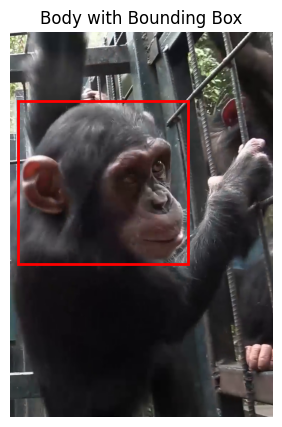

In [ ]:
img = Image.open("C:/Users/julie/Documents/Unif/Mémoire/face_detection_dataset2/images/train/BL38.png")
frame = np.array(img)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title("Body")
plt.axis("off")
plt.show()

with open("C:/Users/julie/Documents/Unif/Mémoire/face_detection_dataset2/labels/train/BL38.txt", "r") as file:
    content = file.readline().strip()
    values = content.split(" ")

values = tuple([float(v) for v in values])

print(values)

height, width, _ = frame.shape

x1,y1,x2,y2 = yolo_to_pixel(values[1:], width, height)
test_image = frame[y1:y2, x1:x2]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image)
plt.title("Face")
plt.axis("off")
plt.show()
